In [1]:
# Import all libraries 
import pandas as pd
import nltk
import re
from nltk.stem.porter import *
import numpy as  np
import gensim
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
import pickle

C:\Users\hp\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\hp\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import os

os.chdir('..')
print("Current Working Directory " , os.getcwd())
#
os.chdir('Datasets')

Current Working Directory  E:\MITB\Text Analytics\Project\Datasets\Submission_folder


In [3]:
# Tagged songs for sentiment analysis load csv file

with open('Tagged_songs_combined_final.csv', encoding='utf-8', errors = 'ignore') as file:
        songs_df = pd.read_csv(file)


In [3]:
# Duplicate songs removal of a song function
def removeDuplicatesLines(k):
    lines_seen = list()
    for line in k:
        if line not in lines_seen:
            lines_seen.append(line)
    clean_lyric = '\n'.join(lines_seen)
    
    return clean_lyric

In [4]:
# Format targeted labels into right format like 'happiness' as 'happy'

songs_df = songs_df.dropna(axis = 0)
songs_df['Polarity'] = songs_df['Polarity'].apply(lambda x: x.lower().replace(" ",""))
songs_df['Emotion']  = songs_df['Emotion'].apply(lambda x: x.lower().replace(" ",""))
songs_df['Emotion'] = songs_df['Emotion'].apply(lambda x: 'happy' if x == 'happiness' else x)
songs_df['Emotion'] = songs_df['Emotion'].apply(lambda x: 'angry' if x == 'anger' else x)
songs_df = songs_df[songs_df.Polarity.isin(['negative','neutral','positive'])].reset_index(drop = True)

In [5]:
# Remove duplicate lines
songs_df['Clean_lyrics'] = songs_df['Lyrics'].apply(lambda x: removeDuplicatesLines(x.splitlines()))

In [6]:
# Data preparation

def songs_to_documents(corpus_data, label):
    labels = list(label)
    dictionary = gensim.corpora.Dictionary(corpus_data)
    labeled_data = []
    for (l,s) in zip(labels,corpus_data):
        vector = dictionary.doc2bow(s)
        sent_as_dict = {id:1 for (id,tf) in vector}
        labeled_data.append((sent_as_dict,l))
    return labeled_data


In [7]:
# Train Naive_bayes function:

def train_naiveBayes(corpus_train, label):
    
    # Model Naive bayes
    labeled_train_data = songs_to_documents(corpus_train,label)
    classifier = nltk.NaiveBayesClassifier.train(labeled_train_data)


    print('Accuracy for train data', nltk.classify.accuracy(classifier,labeled_train_data))
    return classifier



In [8]:
# Test Naive Bayes function
def test_naiveBayes(model,corpus_test,label):
    labeled_test_data = songs_to_documents(corpus_test,label)
    print('Accuracy for test data', nltk.classify.accuracy(model,labeled_test_data))

In [9]:
# Generate n_grams
def generate_ngrams(tokens, n):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [10]:
# Text cleaning: tokenize, lower case, reg check to remove unwanted quotes, stop words removal
def data_clean(songs):
    docs = songs.tolist()
     
    stop_list = nltk.corpus.stopwords.words('english')
    docs2 = [[w.lower() for w in doc] for doc in docs]
    docs3 = [[w for w in doc if re.search('^[a-zA-Z0-9]+$', w)] for doc in docs2]
    docs4 = [[w for w in doc if w not in stop_list] for doc in docs3]

    stemmer = PorterStemmer()
    corpus_clean = [[stemmer.stem(w) for w in doc] for doc in docs4]
    return corpus_clean
    

In [12]:
# Extract negative and positive list
stemmer = PorterStemmer()
pos_lexicon = 'positive-words.txt'
neg_lexicon = 'negative-words.txt'


pos_list = set()
f = open(pos_lexicon, 'r', encoding = "ISO-8859-1")
for line in f:
    line = stemmer.stem(line.strip().lower())
    pos_list.add(line.lower())
f.close()

# Read the negative sentiment lexicon.
neg_list = set()
f = open(neg_lexicon, 'r', encoding = "ISO-8859-1")
for line in f:
    line = stemmer.stem(line.strip())
    neg_list.add(line.lower())
f.close()


In [13]:
# Clean data and create bigrams and tri-grams

songs_df['Lyrics_1'] = data_clean(songs_df['Clean_lyrics'])

songs_df['Lyrics_2'] = songs_df['Lyrics_1'].apply(lambda x: generate_ngrams(x,2))
songs_df['Lyrics_3'] = songs_df['Lyrics_1'].apply(lambda x: generate_ngrams(x,3))

In [14]:
# Data sampling into train and test (80 and 20) percentage
X = songs_df[['Lyrics_1','Lyrics_2','Lyrics_3','Clean_lyrics']]
y = songs_df['Polarity']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,random_state = 42)

In [15]:
# Lexicon model:

# Train data sentimental score
sent_score_train = []
for doc in X_train['Lyrics_1']:
    score = 0
    for word in doc:
        if word in pos_list:
            score = score + 1
        elif word in neg_list:
            score = score-1
    sent_score_train.append(score)

# Accuracy for lexicon
acc_score = 0
y_label = list(y_train)
for i in range(len(sent_score_train)):
    
    if (sent_score_train[i] > 0) & (y_label[i].lower() == 'positive'):
        acc_score = acc_score + 1
    else:
        if (sent_score_train[i] == 0) & (y_label[i].lower() == 'neutral'):
            acc_score = acc_score + 1
        else:
            if (sent_score_train[i] < 0) & (y_label[i].lower() == 'negative'):
                acc_score = acc_score + 1
    
    
    
        
print('Train accuracy for lexicon model:',acc_score/len(sent_score_train))    

# Test data sentimental score
sent_score_test = []
for doc in X_test['Lyrics_1']:
    score = 0
    for word in doc:
        if word in pos_list:
            score = score + 1
        elif word in neg_list:
            score = score-1
    sent_score_test.append(score)

# Accuracy for lexicon
acc_score = 0
y_label = list(y_test)
for i in range(len(sent_score_test)):
    
    if (sent_score_test[i] > 0) & (y_label[i].lower() == 'positive'):
        acc_score = acc_score + 1
    else:
        if (sent_score_test[i] == 0) & (y_label[i].lower() == 'neutral'):
            acc_score = acc_score + 1
        else:
            if (sent_score_test[i] < 0) & (y_label[i].lower() == 'negative'):
                acc_score = acc_score + 1
    
    
    
        
print('Test accuracy for lexicon model:',acc_score/len(sent_score_test))    
    
    

Train accuracy for lexicon model: 0.07308377896613191
Test accuracy for lexicon model: 0.07092198581560284


In [16]:
# NLTK Package Naive Bayes
print('Nltk-model-NaiveBayes for Sentimental analysis')
print('\n')
print('Unigram model')
model_sentiment_naive_nltk_1 = train_naiveBayes(X_train['Lyrics_1'],y_train)
test_naiveBayes(model_sentiment_naive_nltk_1,X_test['Lyrics_1'],y_test)
print('\n')
print('Bigram model')
model_sentiment_naive_nltk_2 = train_naiveBayes(X_train['Lyrics_2'],y_train)
test_naiveBayes(model_sentiment_naive_nltk_2,X_test['Lyrics_2'],y_test)


Nltk-model-NaiveBayes for Sentimental analysis


Unigram model
Accuracy for train data 0.5472370766488414
Accuracy for test data 0.3900709219858156


Bigram model
Accuracy for train data 0.08912655971479501
Accuracy for test data 0.07801418439716312


In [17]:
print('Nltk-Maxent Classifier')
print('\n')

# Train Nltk-Maxent Classifier
numIterations = 100
algorithm = nltk.classify.MaxentClassifier.ALGORITHMS[0]
labeled_train_data = songs_to_documents(X_train['Lyrics_1'],y_train)
model_sentiment_maxent_nltk_1 = nltk.MaxentClassifier.train(labeled_train_data,algorithm,max_iter = numIterations)
print('Accuracy in train data',nltk.classify.accuracy(model_sentiment_maxent_nltk_1,labeled_train_data))
# Test Nltk-Maxent Classifier
labeled_test_data = songs_to_documents(X_test['Lyrics_1'],y_test)
print('Accuracy in test data', nltk.classify.accuracy(model_sentiment_maxent_nltk_1,labeled_test_data))


Nltk-Maxent Classifier


  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.378
             2          -0.89706        0.549
             3          -0.83816        0.549
             4          -0.81545        0.549
             5          -0.80498        0.547
             6          -0.79942        0.549
             7          -0.79599        0.551
             8          -0.79355        0.554
             9          -0.79159        0.556
            10          -0.78989        0.556
            11          -0.78835        0.563
            12          -0.78691        0.561
            13          -0.78557        0.563
            14          -0.78430        0.569
            15          -0.78310        0.569
            16          -0.78197        0.569
            17          -0.78090        0.570
            18          -0.77988        0.570
            19        

In [18]:
# Train Max ent bi gram
numIterations = 100
algorithm = nltk.classify.MaxentClassifier.ALGORITHMS[0]
labeled_train_data = songs_to_documents(X_train['Lyrics_2'],y_train)
model_sentiment_maxent_nltk_2 = nltk.MaxentClassifier.train(labeled_train_data,algorithm,max_iter = numIterations)
print('Accuracy in train data',nltk.classify.accuracy(model_sentiment_maxent_nltk_2,labeled_train_data))
# Test Max ent bi gram
labeled_test_data = songs_to_documents(X_test['Lyrics_2'],y_test)
print('Accuracy in test data', nltk.classify.accuracy(model_sentiment_maxent_nltk_2,labeled_test_data))


  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.378
             2          -1.00063        0.549
             3          -0.93922        0.549
             4          -0.89910        0.549
             5          -0.87175        0.549
             6          -0.85238        0.549
             7          -0.83819        0.549
             8          -0.82750        0.549
             9          -0.81923        0.549
            10          -0.81267        0.549
            11          -0.80735        0.549
            12          -0.80293        0.551
            13          -0.79918        0.551
            14          -0.79594        0.551
            15          -0.79306        0.551
            16          -0.79048        0.551
            17          -0.78811        0.551
            18          -0.78590        0.551
            19          -0.78382        0.551
 

In [19]:
### Sckit learn model

#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',tokenizer = token.tokenize,ngram_range = (1,2))

# tf=TfidfVectorizer(lowercase=True,stop_words='english',ngram_range = (1,2),tokenizer = token.tokenize)


text_counts_train= cv.fit_transform(X_train['Clean_lyrics'])
text_counts_test= cv.transform(X_test['Clean_lyrics'])


from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
model_sentiment_naive_sklearn = MultinomialNB().fit(text_counts_train,y_train)

predicted_train= model_sentiment_naive_sklearn.predict(text_counts_train)
predicted_test= model_sentiment_naive_sklearn.predict(text_counts_test)

print('Sklearn model')
print("MultinomialNB Train Accuracy:",metrics.accuracy_score(y_train, predicted_train))
print("MultinomialNB Test Accuracy:",metrics.accuracy_score(y_test, predicted_test))


Sklearn model
MultinomialNB Train Accuracy: 0.9982174688057041
MultinomialNB Test Accuracy: 0.6312056737588653


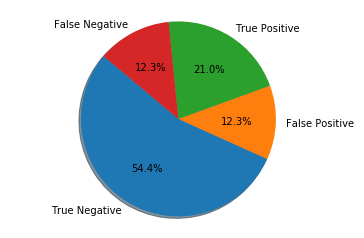

In [21]:
conf_matrix = metrics.confusion_matrix(y_test, predicted_test,labels = ['negative','neutral','positive'])
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)
cnf_list = [sum(TN),sum(FP),sum(TP),sum(FN)]
import matplotlib.pyplot as plt
labels = 'True Negative', 'False Positive ', 'True Positive', 'False Negative'


# Plot
plt.pie(cnf_list, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()


In [22]:
# indicoio Api sentiment analysis, bin into three categories if score less than 0.33 then sentiment tagged as negative 
# bin > 0.33 and bin < 0.7 tagged as neutral
# bin > 0.7 and bin < 1 tagged as positive

songs_df.loc[songs_df['sentiment_score_indicoio']<=0.33,'aut_polarity']='negative'
songs_df.loc[(songs_df['sentiment_score_indicoio']>0.33)&(songs_df['sentiment_score_indicoio']<=0.7),'aut_polarity']='neutral'
songs_df.loc[(songs_df['sentiment_score_indicoio']>0.7),'aut_polarity']='positive'

print('Indicoio Accuracy:',len(songs_df[songs_df.aut_polarity == songs_df.Polarity])/len(songs_df))

Indicoio Accuracy: 0.43447293447293445


In [23]:
X_train.to_csv('Sentiment_train.csv',index = False)

In [24]:
# Emotion analysis

#  train and test data split using sklearn (80 percent train and 20 percent test)

X = songs_df[['Lyrics_1','Lyrics_2','Lyrics_3','Clean_lyrics']]
y = songs_df['Emotion']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,random_state = 42)




In [25]:
# Train and test : Unigram model of emotion 

model_emotion_naive_nltk_1 = train_naiveBayes(X_train['Lyrics_1'],y_train)
test_naiveBayes(model_emotion_naive_nltk_1,X_test['Lyrics_1'],y_test)

Accuracy for train data 0.44206773618538325
Accuracy for test data 0.41843971631205673


In [26]:
# Train and test : Bigram model of emotion 

model_emotion_naive_nltk_2 = train_naiveBayes(X_train['Lyrics_2'],y_train)
test_naiveBayes(model_emotion_naive_nltk_2,X_test['Lyrics_2'],y_test)

Accuracy for train data 0.13368983957219252
Accuracy for test data 0.09929078014184398


In [27]:
### Sckit learn model

#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',tokenizer = token.tokenize,ngram_range = (1,3))

text_counts_train= cv.fit_transform(X_train['Clean_lyrics'])
text_counts_test= cv.transform(X_test['Clean_lyrics'])

from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
model_emotion_naive_sklearn = MultinomialNB().fit(text_counts_train,y_train)

predicted_train= model_emotion_naive_sklearn.predict(text_counts_train)
predicted_test= model_emotion_naive_sklearn.predict(text_counts_test)

print("MultinomialNB Train Emotion Accuracy:",metrics.accuracy_score(y_train, predicted_train))
print("MultinomialNB Test Emotion Accuracy:",metrics.accuracy_score(y_test, predicted_test))


MultinomialNB Train Emotion Accuracy: 0.9982174688057041
MultinomialNB Test Emotion Accuracy: 0.5602836879432624


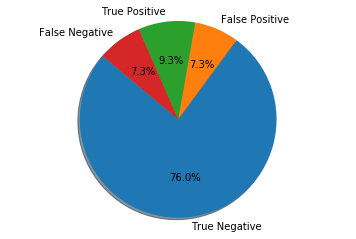

In [28]:
# Visulaization of True negative, True Positive, False Positive and False Negative
conf_matrix = metrics.confusion_matrix(y_test, predicted_test,labels = ['sadness','happy','angry','fear','disgust','surprise'])
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)
cnf_list = [sum(TN),sum(FP),sum(TP),sum(FN)]
import matplotlib.pyplot as plt
labels = 'True Negative', 'False Positive ', 'True Positive', 'False Negative'


# Plot
plt.pie(cnf_list, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()


In [29]:
print('Nltk-Maxent Classifier Emotion')
print('\n')

# Train Nltk Max ent model with 100 iterations unigram
numIterations = 100
algorithm = nltk.classify.MaxentClassifier.ALGORITHMS[0]
labeled_train_data = songs_to_documents(X_train['Lyrics_1'],y_train)
model_emotion_maxent_nltk_1 = nltk.MaxentClassifier.train(labeled_train_data,algorithm,max_iter = numIterations)
print('Accuracy in train data',nltk.classify.accuracy(model_emotion_maxent_nltk_1,labeled_train_data))
# Test unigram emotion
labeled_test_data = songs_to_documents(X_test['Lyrics_1'],y_test)
print('Accuracy in test data', nltk.classify.accuracy(model_emotion_maxent_nltk_1,labeled_test_data))


Nltk-Maxent Classifier Emotion


  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.79176        0.012
             2          -1.29634        0.433
             3          -1.16677        0.433
             4          -1.12037        0.435
             5          -1.09990        0.435
             6          -1.08942        0.431
             7          -1.08328        0.435
             8          -1.07916        0.437
             9          -1.07604        0.437
            10          -1.07344        0.439
            11          -1.07116        0.440
            12          -1.06907        0.444
            13          -1.06713        0.458
            14          -1.06531        0.458
            15          -1.06360        0.458
            16          -1.06197        0.460
            17          -1.06042        0.462
            18          -1.05894        0.465
            19

In [29]:
print('Nltk-Maxent Classifier Emotion Bigram')
print('\n')

# Train Max entropy bigram with 100 iterations
numIterations = 100
algorithm = nltk.classify.MaxentClassifier.ALGORITHMS[0]
labeled_train_data = songs_to_documents(X_train['Lyrics_2'],y_train)
model_emotion_maxent_nltk_2 = nltk.MaxentClassifier.train(labeled_train_data,algorithm,max_iter = numIterations)
print('Accuracy in train data',nltk.classify.accuracy(model_emotion_maxent_nltk_2,labeled_train_data))
# Test max entropy bigram
labeled_test_data = songs_to_documents(X_test['Lyrics_2'],y_test)
print('Accuracy in test data', nltk.classify.accuracy(model_emotion_maxent_nltk_2,labeled_test_data))


Nltk-Maxent Classifier Emotion Bigram


  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.79176        0.012
             2          -1.54751        0.474
             3          -1.40166        0.483
             4          -1.31125        0.492
             5          -1.25224        0.508
             6          -1.21183        0.519
             7          -1.18297        0.522
             8          -1.16162        0.528
             9          -1.14532        0.529
            10          -1.13254        0.535
            11          -1.12227        0.537
            12          -1.11381        0.540
            13          -1.10669        0.542
            14          -1.10058        0.549
            15          -1.09522        0.551
            16          -1.09045        0.554
            17          -1.08612        0.560
            18          -1.08213        0.572
       

In [31]:
# Based on emotional value group bands

df_classify = pd.read_csv('Emotional_scores_500.csv')


In [32]:
# Group band and average of each band

group_by_band = df_classify[['sadness','joy','anger','fear','surprise','Band']].groupby('Band').agg('mean')
group_by_band['Band'] = group_by_band.index
group_by_band = group_by_band.reset_index(drop = True)

In [33]:
X = group_by_band[['sadness','joy','anger','fear','surprise']]

In [34]:
from sklearn.cluster import KMeans

In [35]:
# To determine K value
Sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

In [36]:
import matplotlib.pyplot as plt

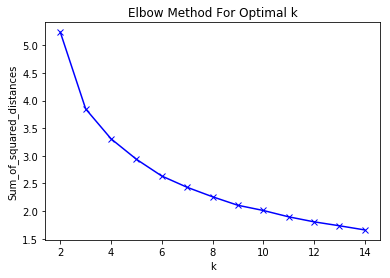

In [37]:
# Plot k value and Sum of squared distances
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [38]:
# From above K = 7, predict clusters
kmeans = KMeans(n_clusters=7, random_state=0).fit(X)
group_by_band['Cluster_number'] = kmeans.predict(X) 